In [1]:
# Determine if this is a benchmarking run
try:
    __benchmark__
except NameError:
    __benchmark__ = False

# Maps and orbital geometry
It can be confusing to think about a map of a planet on an eccentric, inclined orbit at an arbitrary angle on the sky. Let's go through some examples that illustrate how `starry` handles 3D geometry in planet orbits. Note that this tutorial applies only to maps of `starry.Planet` instances. For maps instantiated straight up with `starry.Map`, there's no shenanigans: what you see is what you get!

## Imports

In [2]:
import starry
import numpy as np
import matplotlib.pyplot as pl

In [3]:
%matplotlib inline

To begin, let's instantiate a generic one-planet system with a very close-in, bright, tidally-locked planet:

In [101]:
star = starry.Star()
star.map[1] = 0.4
star.map[2] = 0.26
planet = starry.Planet(L=5e-3, prot=1, porb=1, a=5)
system = starry.System([star, planet])
time = np.linspace(-0.1, 1.1, 100000)

## Edge-on circular orbit, planet with dipole map and centered hotspot

First off, the simplest possible case: an edge-on, circular orbit of a planet with a dipole map whose hotspot always points toward the star. Let's compute and plot the light curve over one orbit:

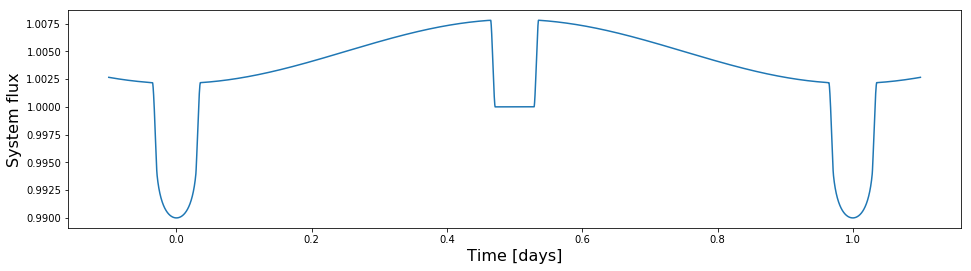

In [69]:
planet.inc = 90
planet.ecc = 0
planet.map[1, 0] = 0.5
system.compute(time)
fig, ax = pl.subplots(1, figsize=(16, 4))
ax.plot(time, system.flux);
ax.set_xlabel('Time [days]', fontsize=16);
ax.set_ylabel('System flux', fontsize=16);

This is exactly what we might expect: two transits at $t = 0$ and $t = 1$, a secondary eclipse at $t = 0.5$, and a phase curve that peaks during secondary eclipse. But it's worth being explicit about what's actually going on. In `starry`, when we instantiate a `Planet` map, we are telling the code that **this is what the planet looks like during secondary eclipse.** In this specific case, we told `starry` that our map looks like this:

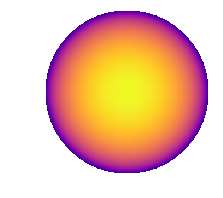

In [70]:
planet.map.show()

Since the map rotates around with the planet, the distinction we made above is necessary. **The coefficients of the map correspond to those of the map seen during secondary eclipse**, when the full dayside of the planet is (or would be, if the star weren't in the way) visible to the observer.

## Eccentric orbits

We can verify that this is still the case regardless of the eccentricity vector of the orbit:

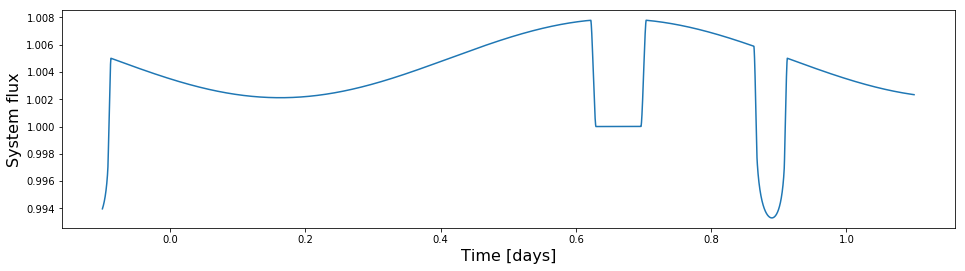

In [58]:
planet.inc = 90
planet.ecc = 0.5
planet.w = 30
planet.map[1, 0] = 0.5
system.compute(time)
fig, ax = pl.subplots(1, figsize=(16, 4))
ax.plot(time, system.flux);
ax.set_xlabel('Time [days]', fontsize=16);
ax.set_ylabel('System flux', fontsize=16);

Secondary eclipse no longer occurs at the same time or mean longitude, but `starry` handles all the necessary rotations behind the scenes. When you specify a map, that is what you'll get when the planet is behind the star!

## Inclined orbits

Now what about inclined orbits, for which there may be no secondary eclipse? **Same thing**: we still specify the map as an observer would see it when looking at the system edge-on.

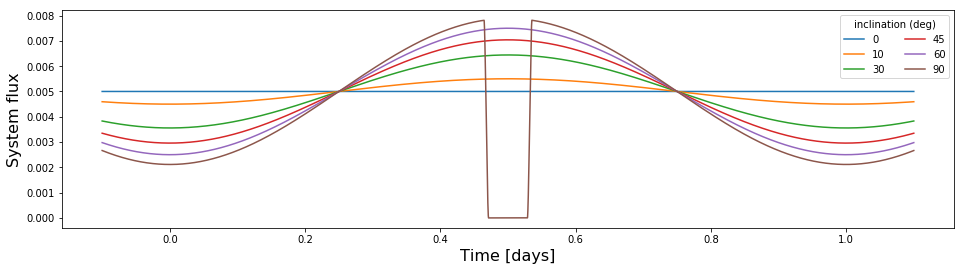

In [102]:
fig, ax = pl.subplots(1, figsize=(16, 4))
planet.ecc = 0
planet.map[1, 0] = 0.5
inclinations = [0, 10, 30, 45, 60, 90]
for inc in inclinations:
    planet.inc = inc
    system.compute(time)
    ax.plot(time, planet.flux, label=inc);
ax.set_xlabel('Time [days]', fontsize=16);
ax.set_ylabel('System flux', fontsize=16);
ax.legend(title='inclination (deg)', ncol=2);

This time I only plotted the *planet's* flux (to get rid of the transits and zoom in on the phase curves). As expected, as the inclination is reduced and the orbit becomes ever more face-on, the amplitude of the planet's phase curve decreases. That's because in all cases, the planet's dipole is always facing the star. Here's what the planet looks like to us, on the *sky* plane, at a mean anomaly $f = \frac{3\pi}{2} - \omega$ (corresponding to secondary eclipse if the orbit is edge on):

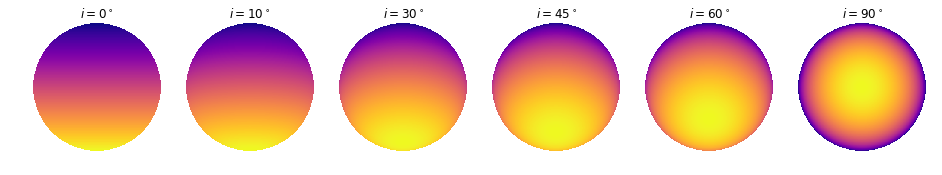

In [90]:
res = 300
fig, ax = pl.subplots(1, 6, figsize=(16, 4))
x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
for i in range(6):
    I = [planet.map.evaluate(axis=[1, 0, 0], theta=90-inclinations[i], x=x[j], y=y[j]) for j in range(res)]
    ax[i].imshow(I, cmap='plasma', origin='lower')
    ax[i].axis('off')
    ax[i].set_title("$i = %d^\circ$" % inclinations[i])

## Rotation in the sky plane

Finally, for the sake of completeness, what about cases where the longitude of ascending node $\Omega \ne 0$? For an edge-on system, this is the angle of rotation of the orbital plane on the sky. Let's see what happens when we specify the same dipole map as before, but vary the longitude of ascending node:

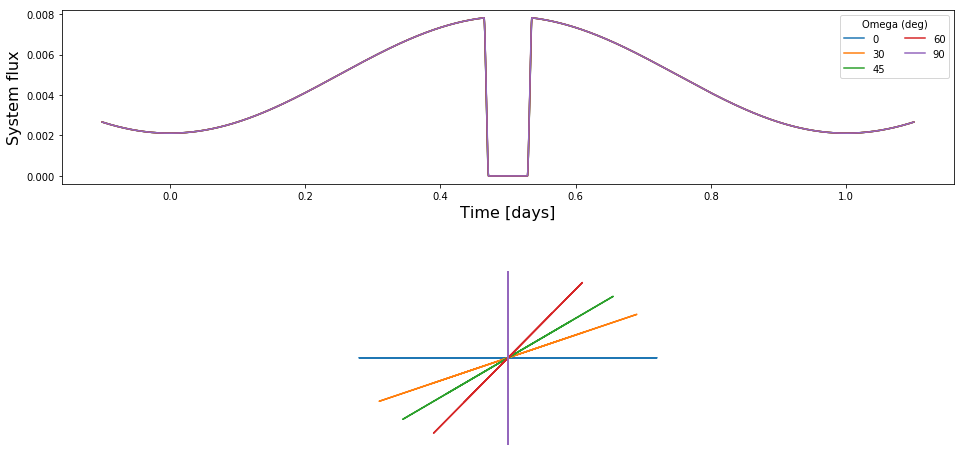

In [100]:
fig, ax = pl.subplots(2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
planet.inc = 90
planet.ecc = 0
planet.map[1, 0] = 0.5
Omegas = [0, 30, 45, 60, 90]
for Omega in Omegas:
    planet.Omega = Omega
    system.compute(time)
    ax[0].plot(time, planet.flux, label=Omega);
    ax[1].plot(planet.x, planet.y, label=Omega)
ax[0].set_xlabel('Time [days]', fontsize=16);
ax[0].set_ylabel('System flux', fontsize=16);
ax[0].legend(title='Omega (deg)', ncol=2);
ax[1].set_ylim(-5, 5);
ax[1].set_xlim(-15, 15);
ax[1].axis('off');

All the light curves are the same, which again is exactly what you'd expect. The longitude of ascending node is not something you can typically probe from a light curve (unless, maybe, with [planet-planet occultations](http://adsabs.harvard.edu/abs/2017ApJ...851...94L))! What this means is that the planet map coefficients are specified as if the planet were seen edge on at secondary eclipse with $\Omega = 0$.

## Summary

Long story short, here's all you need to remember: when you specify the map of a `starry.Planet` instance, you are specifying the coefficients of the map you would see if the system were viewed
1. Edge-on
2. With the planet at secondary eclipse (i.e., directly behind the star)
3. With the orbital plane parallel to the $xy$ axis (that is, $\Omega=0$)